In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep  3 06:58:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

### Amazon product review   Dataset
- https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews?resource=download

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb

Downloading...
From: https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb
To: /content/ratings_Electronics.csv
100% 319M/319M [00:02<00:00, 124MB/s] 


In [ ]:
g=pd.read_csv('ratings_Electronics.csv')

In [ ]:
rating_df =pd.read_csv('ratings_Electronics.csv',  names=['userID','itemID','rating','time'])
rating_df=rating_df[['userID','itemID','rating','time']]



In [ ]:
rating_df.dropna(inplace=True)

In [ ]:

rating_df["itemID"] = rating_df["itemID"].astype(str)
rating_df["userID"] = rating_df["userID"].astype(str)

### Prepare dataset

In [ ]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [ ]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

## Analysis on rating distribution

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


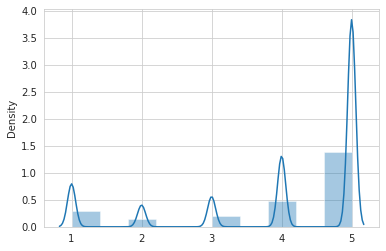

In [ ]:

sns.distplot(x = rating_df['rating'], bins = 10)

In [ ]:
rating_dist=pd.DataFrame(rating_df.groupby('rating', as_index=False)['rating'].agg(['count'])).sort_values(by=['count'],ascending=[False])
rating_dist

,count
rating,
5.0,4347541
4.0,1485781
1.0,901765
3.0,633073
2.0,456322


Observations :
Avarage rating somewhat above 3

### Analyse on impact of time

In [ ]:

rating_df['date']=rating_df['time']

In [ ]:

rating_df['date']=rating_df.date.apply(lambda x: pd.datetime.fromtimestamp(x).date())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
rating_df.sort_values(by="time",ascending=False).head(10)

,userID,itemID,rating,time,date
7516086,A1NXNMRAVPGTO3,B00E98O7GC,5.0,1406073600,2014-07-23
7807561,A1TC07CJU8ROQ2,B00J5OTUOY,5.0,1406073600,2014-07-23
6242775,A2A50YBMOFB4S6,B008HZ595G,5.0,1406073600,2014-07-23
7818529,A30T7JS6OLIYXW,B00K36GUQO,5.0,1406073600,2014-07-23
7823041,ATINSLZVUUGME,B00KMRGF28,5.0,1406073600,2014-07-23
4505389,A3SBTW3WS4IQSN,B004VFGK1I,4.0,1406073600,2014-07-23
7818545,A3VS8VEZBH3KZ7,B00K3EPUZ8,5.0,1406073600,2014-07-23
7807554,AYE0UDHU7HZB9,B00J5OTUOY,5.0,1406073600,2014-07-23
7823061,A2IFGGXG3YV3Y6,B00KMRGF28,4.0,1406073600,2014-07-23
7807565,A1ONP6JYLWATJ5,B00J5OTUOY,5.0,1406073600,2014-07-23


In [ ]:
avg_rating_df = rating_df.groupby('itemID').mean()['rating'].reset_index()
avg_rating_df.rename(columns={'rating':'avg_rating'},inplace=True)
avg_rating_df.sort_values('avg_rating', ascending=[False]).head(10)


,itemID,avg_rating
0,0132793040,5.0
242131,B004SGH244,5.0
242641,B004SQBRRM,5.0
242642,B004SQC6O0,5.0
242644,B004SQE6YI,5.0
242649,B004SQFFCK,5.0
242661,B004SQOR0G,5.0
242672,B004SQVHU4,5.0
242674,B004SQX8W4,5.0
242677,B004SQYSUK,5.0


In [ ]:
total_rating_df = rating_df.groupby('itemID').count()['rating'].reset_index()
total_rating_df.rename(columns={'rating':'num_ratings'},inplace=True)
total_rating_df.sort_values('num_ratings', ascending=[False]).head(10)

,itemID,num_ratings
308398,B0074BW614,18244
429572,B00DR0PDNE,16454
327308,B007WTAJTO,14172
102804,B0019EHU8G,12285
296625,B006GWO5WK,12226
178601,B003ELYQGG,11617
178813,B003ES5ZUU,10276
323013,B007R5YDYA,9907
289775,B00622AG6S,9823
30276,B0002L5R78,9487


In [ ]:
popular_list = total_rating_df.merge(avg_rating_df,on='itemID')
popular_list=popular_list.sort_values(['num_ratings','avg_rating'], ascending=[False,False])
popular_list.head(5)

,itemID,num_ratings,avg_rating
308398,B0074BW614,18244,4.491504
429572,B00DR0PDNE,16454,3.931020
327308,B007WTAJTO,14172,4.424005
102804,B0019EHU8G,12285,4.754497
296625,B006GWO5WK,12226,4.314657


In [ ]:
popularitems=popular_list.itemID.values[:5]

In [ ]:
popularitems

array(['B0074BW614', 'B00DR0PDNE', 'B007WTAJTO', 'B0019EHU8G',
       'B006GWO5WK'], dtype=object)

Trend of rating with time

In [ ]:
item_df=rating_df[rating_df['itemID'].isin(popularitems)]

In [ ]:
item_df['date'] = pd.to_datetime(item_df.date, format='%Y-%m-%d %H:%M:%S')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
item_df['year'] = item_df['date'].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
item_only_df=item_df[['itemID','rating','year']]

In [ ]:
item_only_df=item_only_df[item_only_df.year>=2010]

In [ ]:
item_only_df =item_only_df.groupby(['itemID','year'],as_index=False)['rating'].agg(['count','mean']).reset_index()



In [ ]:
item_only_df.head(5)

,itemID,year,count,mean
0,B0019EHU8G,2010,706,4.580737
1,B0019EHU8G,2011,2185,4.780778
2,B0019EHU8G,2012,4415,4.821744
3,B0019EHU8G,2013,2792,4.700215
4,B0019EHU8G,2014,1547,4.716871


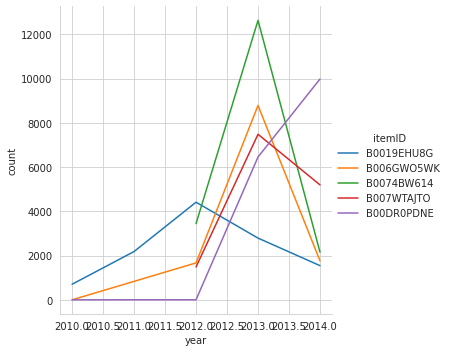

In [ ]:
sns.relplot(x="year", y="count", hue="itemID",
            height=5,
            kind="line", estimator=None, data=item_only_df);

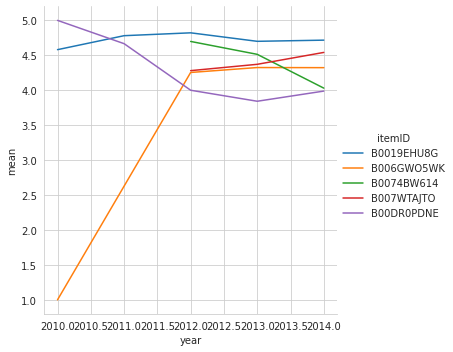

In [ ]:
sns.relplot(x="year", y="mean", hue="itemID",
            height=5,
            kind="line", estimator=None, data=item_only_df);

Observation:
- No specific treand observed

### SAR Algorithm

In [ ]:
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 4.2 MB/s 
     |████████████████████████████████| 636 kB 72.1 MB/s 
     |████████████████████████████████| 61 kB 8.4 MB/s 
     |████████████████████████████████| 355 kB 86.5 MB/s 
     |████████████████████████████████| 12.4 MB 69.0 MB/s 
     |████████████████████████████████| 11.8 MB 80.7 MB/s 
     |████████████████████████████████| 4.7 MB 60.8 MB/s 
     |████████████████████████████████| 197 kB 46.2 MB/s 
     |████████████████████████████████| 310 kB 95.4 MB/s 
     |████████████████████████████████| 390 kB 90.1 MB/s 
     |████████████████████████████████| 120 kB 74.5 MB/s 
     |████████████████████████████████| 6.6 MB 74.2 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705373 sha256=ff85880f23bc81ea6b6d113ffc2e86160e4f6e86e8469b9a1369e7967d4997d0
  Stored in directory: /root/.cache/pip/whe

In [ ]:


from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.sar import SAR


In [ ]:
x = rating_df.groupby('itemID').count()['rating'] > 50
itemIndex = x[x].index
nm_rating_df=rating_df[rating_df['itemID'].isin(itemIndex)]
y = nm_rating_df.groupby('userID').count()['rating']>=50
users = y[y].index
final_ratings = nm_rating_df[nm_rating_df['userID'].isin(users)]

In [ ]:
data = final_ratings[['userID','itemID','rating','time']]
# Convert the float precision to 32-bit in order to reduce memory consumption 


In [ ]:
data.loc[:, 'rating'] = data['rating'].astype(np.float32)

data.head()

,userID,itemID,rating,time
631,A3TAS1AG6FMBQW,0972683275,5.0,1353456000
1335,A2XIOXRRYX0KZY,1400501466,3.0,1371686400
1777,A18S2VGUH9SCV5,1400501776,4.0,1340755200
2162,A5JLAU2ARJ0BO,1400532655,1.0,1291334400
2437,A3HPCRD9RX351S,1400532655,3.0,1332028800


In [ ]:
data.shape

(42857, 4)

In [ ]:
header = {
    "col_user": "userID",
    "col_item": "itemID",
    "col_rating": "rating",
    "col_timestamp": "time",
    "col_prediction": "Prediction",
}
train, test = python_stratified_split(data, ratio=0.8, col_user=header["col_user"], col_item=header["col_item"], seed=42)


In [ ]:
model = SAR(
    similarity_type="jaccard", 
    time_decay_coefficient=30, 
    time_now=None, 
    timedecay_formula=True, 
    **header
)

In [ ]:
model.fit(train)

In [ ]:
top_k = model.recommend_k_items(test, top_k=20, remove_seen=True)


In [ ]:
top_k_with_titles = (top_k.join(data[['itemID']].drop_duplicates().set_index('itemID'), 
                                on='itemID', 
                                how='inner').sort_values(by=['userID', 'Prediction'], ascending=False))
display(top_k_with_titles.head(20))

,userID,itemID,Prediction
11217,AZMY6E8B52L2T,B00GQS290Y,3.479825
11205,AZMY6E8B52L2T,B00HX0RTK4,3.479825
11206,AZMY6E8B52L2T,B007M58WWO,3.479825
11208,AZMY6E8B52L2T,B009T3AHW0,3.479825
11200,AZMY6E8B52L2T,B001K4YWCW,3.479825
11210,AZMY6E8B52L2T,B005IGVXQQ,3.479825
11211,AZMY6E8B52L2T,B00076WOC4,3.479825
11214,AZMY6E8B52L2T,B00G335BJI,3.479825
11213,AZMY6E8B52L2T,B00AANMVNQ,3.479825
11201,AZMY6E8B52L2T,B0087AUCSA,3.479825


In [ ]:
# all ranking metrics have the same arguments
TOP_K=20
args = [test, top_k]
kwargs = dict(col_user='userID', 
              col_item='itemID', 
              col_rating='rating', 
              col_prediction='Prediction', 
              relevancy_method='top_k', 
              k=TOP_K)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

In [ ]:
print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')

Model:
Top K:		 20
MAP:		 0.002560
NDCG:		 0.010602
Precision@K:	 0.007843
Recall@K:	 0.009545


### Catagorical features

In [ ]:
!pip install dython
!pip install matplotlib==3.5.3

In [ ]:
# from dython.nominal import identify_nominal_columns
# categorical_features=identify_nominal_columns(rating_df)
# categorical_features

['userID', 'itemID']

In [ ]:
x = rating_df.groupby('itemID').count()['rating'] > 30
itemIndex = x[x].index
nm_rating_df=rating_df[rating_df['itemID'].isin(itemIndex)]
y = nm_rating_df.groupby('userID').count()['rating']>=30
users = y[y].index
final_ratings = nm_rating_df[nm_rating_df['userID'].isin(users)]

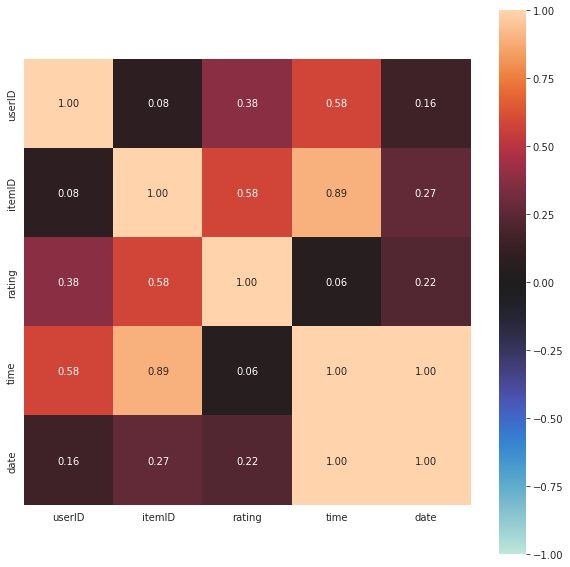

In [ ]:
from dython.nominal import associations
omplete_correlation= associations(final_ratings, filename= 'complete_correlation.png', figsize=(10,10))

### Check sparsity of the data

In [ ]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
features_df = final_ratings.pivot_table(
    index='itemID',
    columns='userID',
    values='rating'
)
# convert dataframe of movie features to scipy sparse matrix

In [ ]:
null=features_df.isna().sum().sum()

In [ ]:
notnull=features_df.count().sum()

In [ ]:
notnull

128798

In [ ]:
null

67873640

In [ ]:
sparsity=(null/(notnull+null))
sparsity

0.9981059796709053

## Bilateral Variational Autoencoder

In [ ]:
x = rating_df.groupby('itemID').count()['rating'] > 50
itemIndex = x[x].index
nm_rating_df=rating_df[rating_df['itemID'].isin(itemIndex)]
y = nm_rating_df.groupby('userID').count()['rating']>=50
users = y[y].index
final_ratings = nm_rating_df[nm_rating_df['userID'].isin(users)]

In [ ]:
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED


In [ ]:
!pip install cornac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import cornac

In [ ]:
bva_df=final_ratings

In [ ]:

# top k items to recommend
TOP_K = 20

# Model parameters
LATENT_DIM = 30
ENCODER_DIMS = [100]
ACT_FUNC = "relu"
LIKELIHOOD = "pois"
NUM_EPOCHS = 200
BATCH_SIZE = 512
LEARNING_RATE = 0.001

In [ ]:
train, test = python_random_split(bva_df, 0.8)


In [ ]:
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

print('Number of users: {}'.format(train_set.num_users))
print('Number of items: {}'.format(train_set.num_items))

Number of users: 561
Number of items: 11197


In [ ]:
bivae = cornac.models.BiVAECF(
    k=LATENT_DIM,
    encoder_structure=ENCODER_DIMS,
    act_fn=ACT_FUNC,
    likelihood=LIKELIHOOD,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    use_gpu=torch.cuda.is_available(),
    verbose=True
)

with Timer() as t:
    bivae.fit(train_set)
print("Took {} seconds for training.".format(t))

  0%|          | 0/200 [00:00<?, ?it/s]

Took 43.5997 seconds for training.


In [ ]:
with Timer() as t:
    all_predictions = predict_ranking(bivae, train, usercol='userID', itemcol='itemID', remove_seen=True)
print("Took {} seconds for prediction.".format(t))

Took 5.5537 seconds for prediction.


In [ ]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.015683
NDCG:	0.055628
Precision@K:	0.037522
Recall@K:	0.049875
